<a href="https://colab.research.google.com/github/groda/big_data/blob/master/Hadoop_Setting_up_Spark_Standalone_on_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://github.com/groda/big_data"><div><img src="https://github.com/groda/big_data/blob/master/logo_bdb.png?raw=true" align=right width="90" alt="Logo Big Data for Beginners"></div></a>
# Install and run Spark in standalone mode
<br>

 Following the instructions at: https://spark.apache.org/docs/latest/spark-standalone.html

You might have to change the constant `HADOOP_SPARK_URL` (the URL for downloading the Hadoop+Spark distribution).

In [ ]:
# URL for downloading Hadoop and Spark
HADOOP_SPARK_URL = "https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz"

## Setup Spark

### Set some environment variables

In [ ]:
import os
os.environ['HADOOP_SPARK_URL'] = HADOOP_SPARK_URL
os.environ['SPARK_HOME'] = os.path.join('/content', os.path.splitext(os.path.basename(HADOOP_SPARK_URL))[0])
os.environ['PATH'] = ':'.join([os.path.join(os.environ['SPARK_HOME'], 'bin'), os.environ['PATH']])
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

### Download package and unpack

**Note:** using `--no-clobber` option will prevent `wget` from downloading file if already present.

In [ ]:
!wget --no-clobber $HADOOP_SPARK_URL

File ‘spark-3.3.1-bin-hadoop3.tgz’ already there; not retrieving.



In [ ]:
!([ -f $(basename ${HADOOP_SPARK_URL}|sed 's/\.[^.]*$//') ] && echo "Folder already exists") || (tar xzf $(basename $HADOOP_SPARK_URL) && echo "Uncompressed")


Uncompressed


Check

In [ ]:
!ls

sample_data  spark-3.3.1-bin-hadoop3  spark-3.3.1-bin-hadoop3.tgz


### Start a standalone master

First, stop Spark master and all workers in case there's some already running.

In [ ]:
%%bash
$SPARK_HOME/sbin/stop-master.sh 
$SPARK_HOME/sbin/stop-worker.sh 


no org.apache.spark.deploy.master.Master to stop
stopping org.apache.spark.deploy.worker.Worker


In [ ]:
!ls $SPARK_HOME

bin   data	jars	    LICENSE   logs    python  README.md  sbin  yarn
conf  examples	kubernetes  licenses  NOTICE  R       RELEASE	 work


In [ ]:
%%bash --out output
$SPARK_HOME/sbin/start-master.sh

#### Extract port number for the Spark Web UI
We captured the `output` in order to get the name of the logfile and extract from it the URL of the Spark Web UI. 

Here's the name of the master's logfile: 

In [ ]:
!echo $(echo "$output" | grep -o '[^ ]*$')

/content/spark-3.3.1-bin-hadoop3/logs/spark--org.apache.spark.deploy.master.Master-1-8ef76e05a45f.out


Extract port where MasterUI (the Web interface for Spark's master) is running:

In [ ]:
%%bash
PORT=$(grep  -m1 -Po "Successfully started service 'MasterUI' on port \d+" $SPARK_HOME/logs/spark--org.apache.spark.deploy.master.Master*.out| cut -d' ' -f7)
echo $PORT

In [ ]:
%env PORT=8081

env: PORT=8081


### Start one worker

In order to start a worker you need the URL for the running master node, that is something like `spark://${HOSTNAME}:7077`




In [ ]:
!$SPARK_HOME/sbin/start-worker.sh spark://${HOSTNAME}:7077

starting org.apache.spark.deploy.worker.Worker, logging to /content/spark-3.3.1-bin-hadoop3/logs/spark--org.apache.spark.deploy.worker.Worker-1-8ef76e05a45f.out


## Look at the master's Web UI

<a id='SparkWebUI'></a>Open the WebUI in a new window or tab in your browser buy clicking on the link below:

In [ ]:
from google.colab import output
output.serve_kernel_port_as_window(8081)

<IPython.core.display.Javascript object>

## Run a Spark job with `spark-submit`

This step might take some time. 

We are going to run the SparkPi demo from the examples in the Spark distribution contained in `spark-examples*.jar`. 

We are submitting the job with [`spark-submit`](https://spark.apache.org/docs/latest/submitting-applications.html). The output of this job is an approximation of π (see also https://spark.apache.org/examples.html).

In [ ]:
%%bash

export EXAMPLES_JAR=$(find $SPARK_HOME/examples/jars/ -name "spark-examples_2*")

$SPARK_HOME/bin/spark-submit \
  --class org.apache.spark.examples.SparkPi \
  --master spark://${HOSTNAME}:7077 \
  --executor-memory 2G \
  --total-executor-cores 100 \
  $EXAMPLES_JAR \
  100

22/10/27 23:01:09 INFO SparkContext: Running Spark version 3.3.1
22/10/27 23:01:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/27 23:01:10 INFO ResourceUtils: ==============================================================
22/10/27 23:01:10 INFO ResourceUtils: No custom resources configured for spark.driver.
22/10/27 23:01:10 INFO ResourceUtils: ==============================================================
22/10/27 23:01:10 INFO SparkContext: Submitted application: Spark Pi
22/10/27 23:01:10 INFO ResourceProfile: Default ResourceProfile created, executor resources: Map(cores -> name: cores, amount: 1, script: , vendor: , memory -> name: memory, amount: 2048, script: , vendor: , offHeap -> name: offHeap, amount: 0, script: , vendor: ), task resources: Map(cpus -> name: cpus, amount: 1.0)
22/10/27 23:01:10 INFO ResourceProfile: Limiting resource is cpu
22/10/27 23:01:10 INFO ResourceProfileManager: Add

While the job is running you can check the progress in the Spark GUI (link in previous cell).

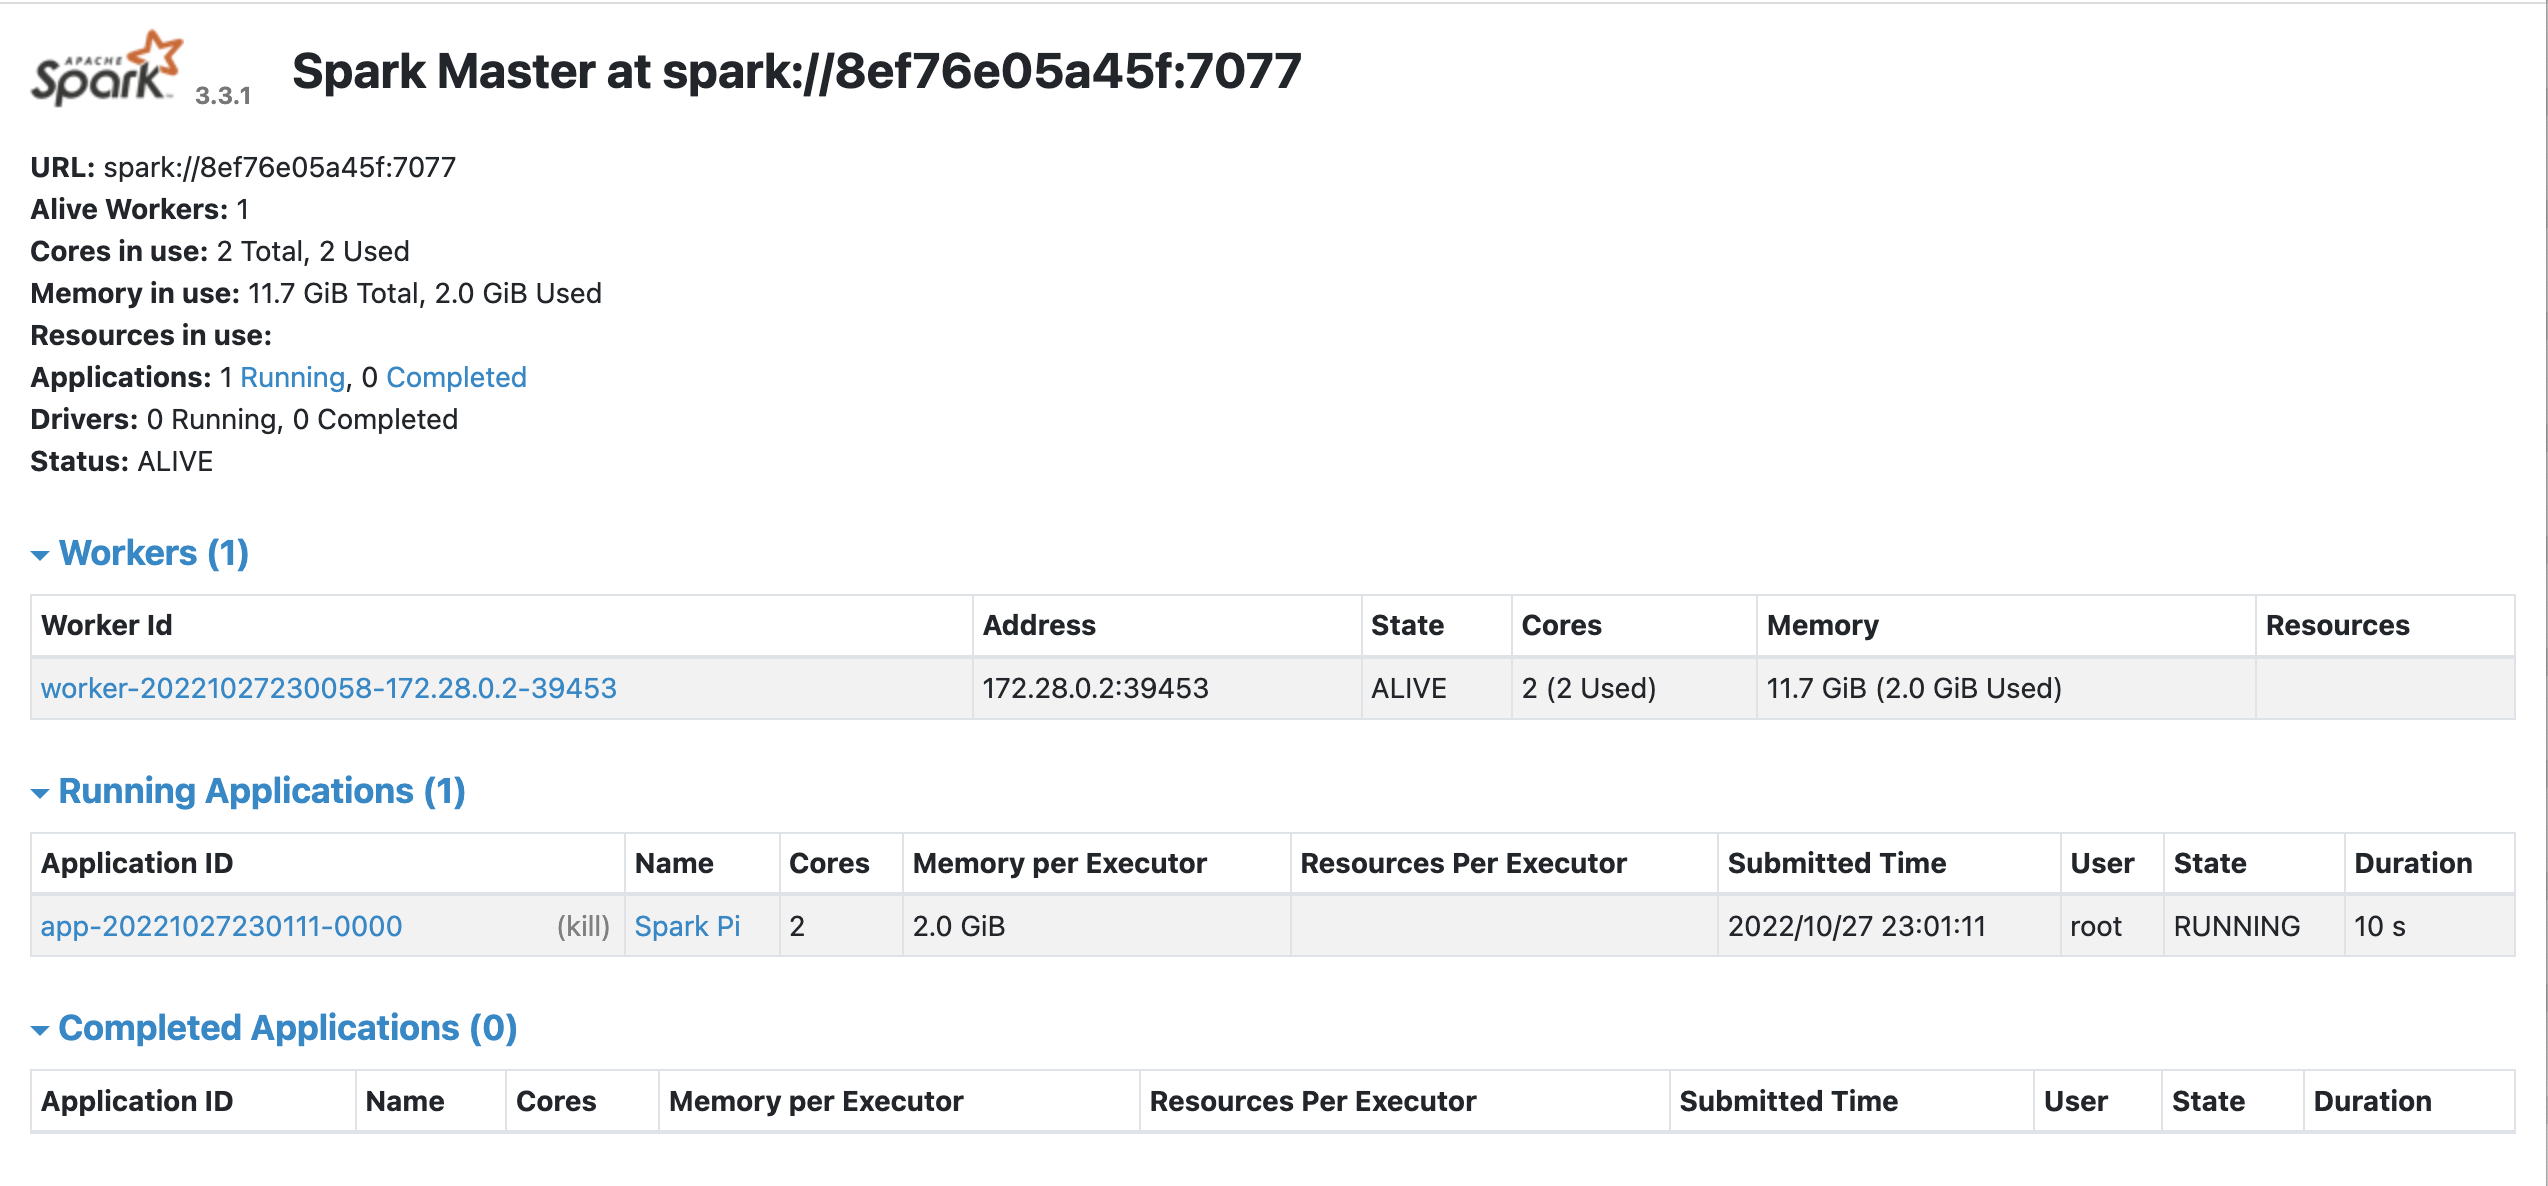

## Shutdown 

In [ ]:
%%bash
$SPARK_HOME/sbin/stop-master.sh 
$SPARK_HOME/sbin/stop-worker.sh

stopping org.apache.spark.deploy.master.Master
stopping org.apache.spark.deploy.worker.Worker
